# Classification de roches

## Import

Nous disposons d'un certains nombres d'images classées sous plusieurs catégories. A partir de toutes ces données, on veut pouvoir construire un modèle permettant de prédire la classe à laquelle appartient une image donnée.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D

import torchvision.datasets as datasets
from torchvision import transforms

import cv2
import os

from google.colab import drive

## Dataset

On commence par charger les données brutes qui sont à notre disposition, pour celà :
* On réorganise les images de telle sorte que chaque image appartenant à une classe se trouve dans le dossier correspondant à cette dernière.
* On importe ensuite les données à l'aide de la fonction `image_dataset_from_directory` de `keras`, prenant comme paramètres le répertoire où se trouve les images.

In [ ]:
# mount drive for loading data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#fonction pour normaliser les données
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [ ]:
dataset = image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/Colab Notebooks/Rocks/Rocks",
    labels="inferred",
    label_mode='categorical',
    batch_size=None,
    image_size=(150,150),
    shuffle=False
)

Found 8524 files belonging to 4 classes.


In [ ]:
dataset = dataset.map(process)
#data_val = data_val.map(process)

In [ ]:
dataset0 = datasets.ImageFolder(root="/content/gdrive/MyDrive/Colab Notebooks/Rocks/Rocks")

In [ ]:
data = []
label = []

with tf.device("/device:GPU:0"):
  for i, elem in enumerate(dataset):
    print(i)
    a, b = elem
    data.append(a)
    label.append(b)

len(data), len(label)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
37

(8524, 8524)

In [ ]:
data = np.array(data)
label = np.array(label)

data.shape, label.shape

((8524, 150, 150, 3), (8524, 4))

## EDA

In [ ]:
y = label.argmax(1)

Avant de mettre en place des modèles, on va d'abord étudier les caractéristiques des images.

### Visualisation

On dispose d'images de roches classifiées selon 4 catégories :
* Le dataset est composé de 8524 images de tailles 150x150 sur 3 canaux.
* Les données sont réparties sur 4 classes : fines, large, medium, pellets

Label : fines (0)

Les roches de classe "fines" sont très fines

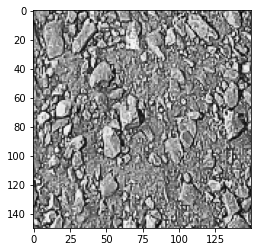

In [ ]:
img = data[y == 0][0].astype(int)
plt.imshow(img)

label : large (1)

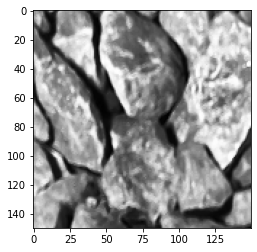

In [ ]:
img = data[y == 1][0].astype(int)
plt.imshow(img)

label : medium (2)

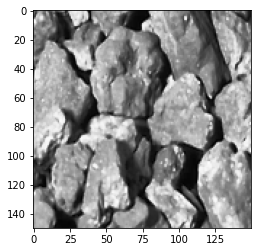

In [ ]:
img = data[y == 2][0].astype(int)
plt.imshow(img)

label : pellets (3)

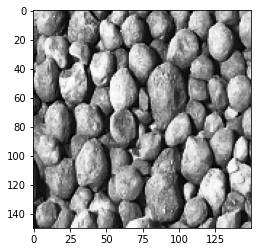

In [ ]:
img = data[y == 3][0].astype(int)
plt.imshow(img)

In [ ]:
label_names = ["fines", "large", "medium", "pellets"]

#### Vue d'ensemble de chaque catégorie :
On va visualiser 10 éléments de chaque classe pour voir à quoi ressemble les données de chaque catégorie :    
* (1) : large
* (2) : fines
* (3) : medium
* (4) : pellets

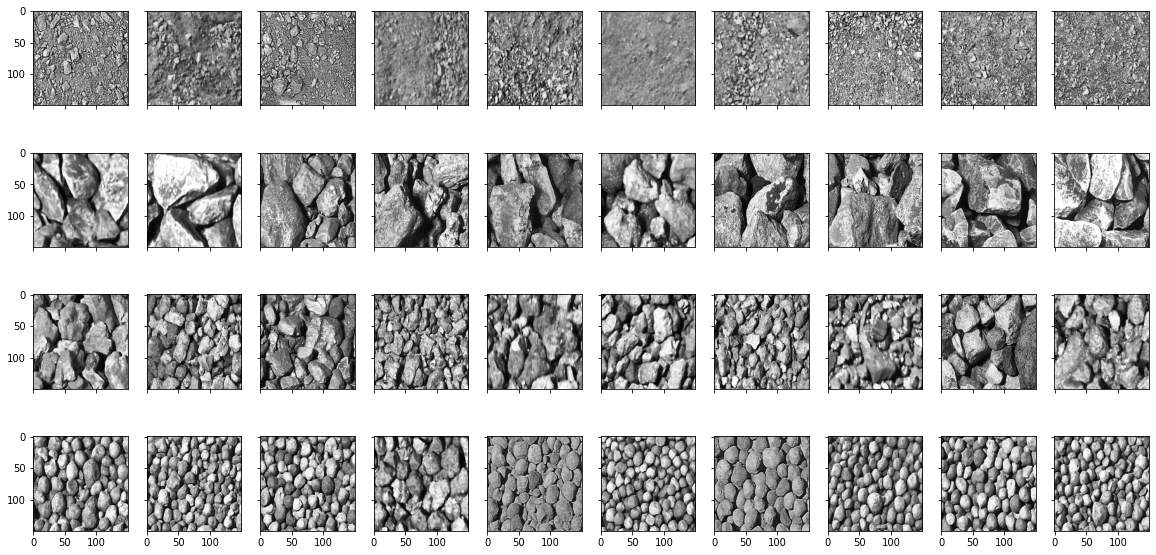

In [ ]:
fig, axes = plt.subplots(4, 10, sharex=True, sharey=True, figsize=(20,10))

for i in range(4):
    for j in range(10):
        f = data[y == i][j].astype(int)

        axes[i,j].imshow(f)

plt.show()

TAILLE DES IMAGES ET NOMBRE DE CANAUX

Nous allons vérifier que toutes les images du dataset ont les mêmes dimensions et le même nombre de canaux, pour cela, on ne va pas utiliser la fonction `image_dataset_from_directory` de `keras` pour les charger, on va s'attaquer aux données brutes.

In [ ]:
#getting data from folder
dataset_folder = "/content/gdrive/MyDrive/Colab Notebooks/Rocks/Rocks"

folders = os.listdir(dataset_folder)
images = [] #all of the images
images_taille_224 = [] #images with size 224
image_shapes = [] # contains all image's shape
image_channel = [] #contains all image's channel
images_taille_150 = 0 #number of images with size 150

for folder in folders:
  folder_path = os.path.join(dataset_folder, folder)
  for path in os.listdir(folder_path):
    image_path = os.path.join(os.path.join(dataset_folder, folder), path)
    image = cv2.imread(image_path)

    # Convert to RGB as OpenCV uses BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

    # Obtain channel's number of each image
    channel = len(image.shape)
    image_channel.append(channel)

    # Obtain shape of each image and store them in an array
    (width, height) = image.shape[1], image.shape[0]
    image_shapes.append((width, height))

    # Count image with the same shape
    if(width == 224):
      images_taille_224.append(image)

    if(width == 150):
      images_taille_150 = images_taille_150 + 1

# Return only unique shapes
unique_shapes = list(set(image_shapes))
unique_channel = list(set(image_channel))

Après constat, on a vu à travers les 8524 images :
* la taille de la majorité des images est de 150x150 ou de 224x224.
* Le nombre de canaux de couleur de chaque image est 3: RGB.

In [ ]:
print("Nombre total d'images: ", len(images))
print("Nombre de canaux par image: ", unique_channel)
print("Taille des images: ", unique_shapes)

Nombre total d'images:  8524
Nombre de canaux par image:  [3]
Taille des images:  [(224, 224), (150, 150)]


In [ ]:
print("Nombre d'image de taille 150x150: ", images_taille_150)
print("Nombre d'image de taille 224x224: ", len(images_taille_224))

Nombre d'image de taille 150x150:  8522
Nombre d'image de taille 224x224:  2


La taille des images ne sont pas uniformes. 2 images sur 8524 (nombre total des images) sont de taille 224x224 alors que la taille du reste est 150x150.

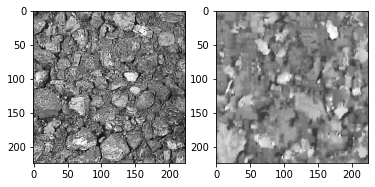

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(images_taille_224[0])
axes[1].imshow(images_taille_224[1])

DISTRIBUTION DE COULEUR

On a pris la moyenne des valeurs de chaque image, la liste `mean_values` contient donc la moyenne de chacune des `images`

In [ ]:
# Obtain the mean of all channels of the RGB space of the image
mean_values = []
for i in range(len(images)):
  mean_value = np.mean(images[i])
  mean_values.append(mean_value)

Ici, on représente sur ce graphe la distribution des moyennes par canaux que l'on a calculé précedemment.

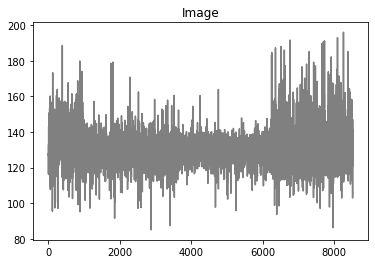

In [ ]:
# Representation of the mean of all channels for each image
fig, ax = plt.subplots()
ax.plot(list(range(8524)), mean_values, color = 'grey')
ax.set_title('Image')
plt.show()

In [ ]:
print("La valeur minimale de la moyenne des canaux: ", min(mean_values))
print("La valeur maximale de la moyenne des canaux: ", max(mean_values))
print("La moyenne des canaux: ", sum(mean_values)/len(mean_values))

La valeur minimale de la moyenne des canaux:  84.98777777777778
La valeur maximale de la moyenne des canaux:  196.0154222222222
La moyenne des canaux:  130.86455365373976


DISTRIBUTION PAR CLASSE

In [ ]:
label_names

['fines', 'large', 'medium', 'pellets']

On va voir la distribution de nos données par rapport à chaque classe

In [ ]:
bins = [sum(y==0), sum(y==1), sum(y==2), sum(y==3)]
bins

[997, 2278, 2673, 2576]

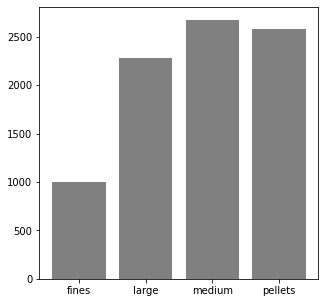

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x=label_names, height=bins, color='grey')
plt.show()

La répartition des données n'est pas uniforme vu que la classe 'fines' contient deux fois moins de données que les autres classes. Les 3 autres  ont en moyenne 2300 images.

Donc pour les données d'entraînement, on va essayer de générer des images par transformations géométriques pour la classe "fines" afin d'équilibrer le nombre .

## Preprocessing

### Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42,stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((5455, 150, 150, 3),
 (5455, 4),
 (1705, 150, 150, 3),
 (1705, 4),
 (1364, 150, 150, 3),
 (1364, 4))

On va diviser nos données en 3 :
* validation : 20%
* test : 20%
* entraînement : 60%

### Data Augmentation


Avant de compiler notre modèle, on va revoir la répartition des classes pour savoir comment on va augmenter nos données

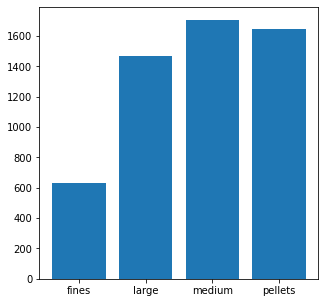

In [ ]:
label_repartition = [sum(y_train.argmax(1)==0), sum(y_train.argmax(1)==1), sum(y_train.argmax(1)==2), sum(y_train.argmax(1)==3)]
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x=label_names, height=label_repartition)
plt.show()

In [ ]:
print("nombre de roche de classe 'fines' : ", label_repartition[0])

nombre de roche de classe 'fines' :  633


La classe `fines` étant en sous nombre, on va les augmenter en appliquant quelques transformations n'affectant pas la reconnaissance des images :
* Symétrie d'axes (x et y)
* rotation
* translation
* zoom

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
)

In [ ]:
datagen.fit(X_train)
img_iter = datagen.flow(X_train, y_train, batch_size=32)

## Modeling

On va passer à la phase de création de modèles, pour cela on a d'abord tester plusieurs modèles dont les suivants :
* (1) Modèle de réseau de neurones simple (6 couches)
* (2) ResNet101
* (3) MobileNetV2
* (4) VGG16
* (5) MobileNetv1

Ensuite, on a choisi les 3 meilleures modèles pour ensuite avoir la meilleure performance avec un Ensemble learning. On a constaté que les 3 meilleures modèles ont été ResNet101, MobileNet et VGG16 .





#### Modèle simple

In [ ]:
num_classes = 4

Implémentation du modèle

In [ ]:

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1/127.0, offset=-1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

Loss function + compilation du modèle

In [ ]:
lr=0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

On entraine le modèle avec `img_iter` (X_train augmenté) avec `X_val` et `y_val` comme données de validation

In [ ]:
model.fit(img_iter, validation_data=(X_val, y_val) ,epochs=6,batch_size=32)

Epoch 1/6
171/171 [==============================] - 30s 164ms/step - loss: 0.6872 - accuracy: 0.6913 - val_loss: 0.4914 - val_accuracy: 0.7874
Epoch 2/6
171/171 [==============================] - 26s 152ms/step - loss: 0.4055 - accuracy: 0.8227 - val_loss: 0.3867 - val_accuracy: 0.8438
Epoch 3/6
171/171 [==============================] - 26s 152ms/step - loss: 0.3538 - accuracy: 0.8497 - val_loss: 0.3293 - val_accuracy: 0.8666
Epoch 4/6
171/171 [==============================] - 26s 150ms/step - loss: 0.3181 - accuracy: 0.8631 - val_loss: 0.3095 - val_accuracy: 0.8717
Epoch 5/6
171/171 [==============================] - 26s 151ms/step - loss: 0.2972 - accuracy: 0.8726 - val_loss: 0.2877 - val_accuracy: 0.8849
Epoch 6/6
171/171 [==============================] - 26s 151ms/step - loss: 0.3011 - accuracy: 0.8680 - val_loss: 0.3655 - val_accuracy: 0.8548


Backup du modèle pour future utilisation

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/model_simple.h5')

Score avec les données de test

In [ ]:
loss , accuracy = model.evaluate(X_test, y_test)
print('accuracy: ' + str(accuracy))

54/54 [==============================] - 1s 13ms/step - loss: 0.3263 - accuracy: 0.8686
accuracy: 0.8686217069625854


### ResNet101

In [ ]:
#Importing the Resnet Model
resnet_model = ResNet101(
    include_top = False,
    weights = 'imagenet',
    input_shape = (150,150,3)
)

# Freeze
for layer in resnet_model.layers:
    layer.trainable = False

171446536/171446536 [==============================] - 9s 0us/step


In [ ]:
#Converting the output layer as per our dataset
model=tf.keras.models.Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
adm=tf.keras.optimizers.Adam(learning_rate=0.001)
opt=adm
epochs=5

In [ ]:
model.compile(
    optimizer = opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(img_iter ,validation_data=(X_val, y_val), epochs=epochs)

Epoch 1/5
171/171 [==============================] - 48s 206ms/step - loss: 0.6602 - accuracy: 0.7226 - val_loss: 0.5323 - val_accuracy: 0.8028
Epoch 2/5
171/171 [==============================] - 33s 193ms/step - loss: 0.5235 - accuracy: 0.7732 - val_loss: 0.4152 - val_accuracy: 0.8284
Epoch 3/5
171/171 [==============================] - 33s 191ms/step - loss: 0.4901 - accuracy: 0.7877 - val_loss: 0.5476 - val_accuracy: 0.7764
Epoch 4/5
171/171 [==============================] - 33s 191ms/step - loss: 0.4916 - accuracy: 0.7883 - val_loss: 0.4796 - val_accuracy: 0.7955
Epoch 5/5
171/171 [==============================] - 33s 191ms/step - loss: 0.4687 - accuracy: 0.7965 - val_loss: 0.4545 - val_accuracy: 0.8130


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/model_resnet101.h5')

In [ ]:
loss , accuracy = model.evaluate(X_test, y_test)
print('accuracy: ' + str(accuracy))

54/54 [==============================] - 5s 100ms/step - loss: 0.4630 - accuracy: 0.8076
accuracy: 0.8076246380805969


### MobileNetV2

In [ ]:
mobilev3 =tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape=(150,150,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential()
model.add(mobilev3)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
lr=0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(img_iter,validation_data=(X_val, y_val), epochs=6)

Epoch 1/6
171/171 [==============================] - 32s 167ms/step - loss: 1.5707 - accuracy: 0.8075 - val_loss: 0.3786 - val_accuracy: 0.8688
Epoch 2/6
171/171 [==============================] - 27s 157ms/step - loss: 0.3830 - accuracy: 0.8513 - val_loss: 0.3429 - val_accuracy: 0.8783
Epoch 3/6
171/171 [==============================] - 28s 165ms/step - loss: 0.3758 - accuracy: 0.8473 - val_loss: 0.4202 - val_accuracy: 0.8622
Epoch 4/6
171/171 [==============================] - 27s 158ms/step - loss: 0.3730 - accuracy: 0.8422 - val_loss: 0.3231 - val_accuracy: 0.8732
Epoch 5/6
171/171 [==============================] - 30s 173ms/step - loss: 0.3937 - accuracy: 0.8387 - val_loss: 0.3270 - val_accuracy: 0.8790
Epoch 6/6
171/171 [==============================] - 27s 158ms/step - loss: 0.3729 - accuracy: 0.8464 - val_loss: 0.4296 - val_accuracy: 0.8416


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/xception.h5')

In [ ]:
loss , accuracy = model.evaluate(X_test, y_test)
print('accuracy: ' + str(accuracy))

54/54 [==============================] - 2s 30ms/step - loss: 0.4095 - accuracy: 0.8434
accuracy: 0.8434017300605774


### VGG16

In [ ]:
vgg16 =tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape=(150,150,3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
lr=0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(img_iter,validation_data=(X_val, y_val), epochs=6)

Epoch 1/6
171/171 [==============================] - 37s 204ms/step - loss: 2.2456 - accuracy: 0.8359 - val_loss: 0.4104 - val_accuracy: 0.8908
Epoch 2/6
171/171 [==============================] - 33s 191ms/step - loss: 0.3934 - accuracy: 0.8647 - val_loss: 0.3859 - val_accuracy: 0.8922
Epoch 3/6
171/171 [==============================] - 32s 186ms/step - loss: 0.3264 - accuracy: 0.8920 - val_loss: 0.3139 - val_accuracy: 0.8900
Epoch 4/6
171/171 [==============================] - 33s 192ms/step - loss: 0.3171 - accuracy: 0.8874 - val_loss: 0.2549 - val_accuracy: 0.9003
Epoch 5/6
171/171 [==============================] - 32s 186ms/step - loss: 0.3036 - accuracy: 0.8830 - val_loss: 0.2698 - val_accuracy: 0.9025
Epoch 6/6
171/171 [==============================] - 32s 186ms/step - loss: 0.2845 - accuracy: 0.8895 - val_loss: 0.2906 - val_accuracy: 0.9135


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/vgg16.h5')

In [ ]:
loss , accuracy = model.evaluate(X_val, y_val)
print('accuracy: ' + str(accuracy))

43/43 [==============================] - 4s 81ms/step - loss: 0.2906 - accuracy: 0.9135
accuracy: 0.9134897589683533


### MobileNet





In [ ]:
mobilev1 =tf.keras.applications.MobileNet(weights = 'imagenet', include_top = False, input_shape=(150,150,3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential()
model.add(mobilev1)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
lr=0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(img_iter,validation_data=(X_val, y_val), epochs=6)

Epoch 1/6
171/171 [==============================] - 29s 162ms/step - loss: 0.7264 - accuracy: 0.8233 - val_loss: 0.3038 - val_accuracy: 0.8820
Epoch 2/6
171/171 [==============================] - 27s 156ms/step - loss: 0.3503 - accuracy: 0.8570 - val_loss: 0.3062 - val_accuracy: 0.8871
Epoch 3/6
171/171 [==============================] - 27s 155ms/step - loss: 0.3541 - accuracy: 0.8607 - val_loss: 0.2953 - val_accuracy: 0.8937
Epoch 4/6
171/171 [==============================] - 27s 155ms/step - loss: 0.3240 - accuracy: 0.8649 - val_loss: 0.2696 - val_accuracy: 0.8952
Epoch 5/6
171/171 [==============================] - 28s 163ms/step - loss: 0.3392 - accuracy: 0.8625 - val_loss: 0.3014 - val_accuracy: 0.8974
Epoch 6/6
171/171 [==============================] - 27s 155ms/step - loss: 0.3327 - accuracy: 0.8687 - val_loss: 0.3111 - val_accuracy: 0.8886


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/mobilev1.h5')

In [ ]:
loss , accuracy = model.evaluate(X_val, y_val)
print('accuracy: ' + str(accuracy))

43/43 [==============================] - 1s 22ms/step - loss: 0.3111 - accuracy: 0.8886
accuracy: 0.8885630369186401


### Ensemble learning

On va utiliser l' Ensemble Learning pour avoir un meilleur score, les modèles que l'on va utiliser sont :    
* vgg16
* mobilenetv1
* resnet101

On charge les modèles à partir des fichiers de sauvegarde que l'on a faite auparavant.

In [ ]:

model1 = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/vgg16.h5')
model2 = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/model_resnet101.h5')
model3 = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/mobilev1.h5')

Cette fonction définie la prédiction sur l'ensemble des 3 modèles pour avoir une meilleure performance.

In [ ]:
models = [model1, model2, model3]

def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  #print(yhats.shape)

  #print(yhats)
  sum = 0.5*yhats[0]+0.3*yhats[1]+0.2*yhats[2]

  result = np.argmax(sum, axis=1)
  return result

In [ ]:
predictions =  ensemble_predictions(models, X_test)

54/54 [==============================] - 2s 21ms/step


In [ ]:
y_flat = y_test.argmax(1)

In [ ]:
print('accuracy: ' + str(np.sum(np.array(y_flat==predictions))/y_flat.shape[0]))

accuracy: 0.9102639296187683


Finalement, l'ensemble a donné une amélioration de performances que celle des modèles individuelles